In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

import eli5

from sklearn.preprocessing import MultiLabelBinarizer

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin

from sklearn.feature_extraction.text import TfidfVectorizer

from skmultilearn.problem_transform import BinaryRelevance
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

import sklearn.metrics as metrics

from gensim import utils
import gensim.parsing.preprocessing as gsp

import joblib

# Functions

In [2]:
# Définition d'une fonction permettant d'afficher la matrice de confusion et l'accuracy
def plot_confusion_matrix(y_true, y_pred, labels = [0, 1]):
    #Calculate accuracy and confusion matrix
    accuracy = metrics.accuracy_score(y_true, y_pred)
    cm = metrics.multilabel_confusion_matrix(y_true, y_pred)
    
    #Plot confusion matrix
    plt.figure(figsize=(7,7))
    ax = sns.heatmap(cm, annot= True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues_r', 
                     xticklabels = labels, yticklabels = labels);
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.1, top - 0.1)
    plt.ylabel('Actual label');
    plt.xlabel('Predicted label');
    all_sample_title = 'Accuracy: {:.3f}'.format(accuracy)
    plt.title(all_sample_title, size = 15);
    return 

# Load data

In [3]:
# Read csv and create list of tags 
df = pd.read_csv('in/StackOverflow_50000_posts.csv')
df = df[['Id', 'Title', 'Body', 'Tags']]

df['Post'] = df['Title'] + ' ' + df['Body']
df.drop(columns = ['Title', 'Body'], inplace = True)

df['Tags'] = df['Tags'].str.findall(r'<(.*?)>')
df['nTags'] = df['Tags'].apply(len)

In [4]:
df = df.loc[0:499, :]
n_posts = df['Id'].count()

In [5]:
# Create tags matrix of size n_obs * n_tags
mlb = MultiLabelBinarizer(sparse_output = False)
df_tags = pd.DataFrame(mlb.fit_transform(df['Tags']), columns = mlb.classes_, index = df.index)

# Analyze tags

In [6]:
# Sort df_tags per number of occurences 
df_tags_unique = pd.DataFrame(df_tags.sum(axis = 0).sort_values(ascending = False), columns = ['n_occurence'])
df_tags = df_tags[df_tags_unique.index]

In [7]:
# Calculate cumulative percentage of tags
n_total_tags = df_tags.sum().sum()
df_tags_unique['pct_tags'] = df_tags_unique.cumsum(axis = 0) / n_total_tags * 100
n_total_tags

1496

In [8]:
# Calculate what % of posts are covered by at least one tag 
df_tmp = pd.DataFrame(index = df_tags.index, columns = ['Tagged'])
df_tmp['Tagged'] = 0

for col in df_tags:
    df_tmp['Tagged'] = df_tmp['Tagged'] | df_tags[col]
    df_tags_unique.loc[col, 'n_posts'] = df_tmp['Tagged'].sum()
    
df_tags_unique['pct_posts'] = df_tags_unique['n_posts'] / n_posts * 100

# Reset index to create tag col
df_tags_unique = df_tags_unique.reset_index().rename(columns = {'index': 'tag'})

n_tags_unique = df_tags_unique['tag'].count()
n_tags_unique

764

In [9]:
df_tags_unique

,tag,n_occurence,pct_tags,n_posts,pct_posts
0,python,89,5.949198,89.0,17.8
1,javascript,43,8.823529,132.0,26.4
2,java,37,11.296791,168.0,33.6
3,r,29,13.235294,197.0,39.4
4,python-3.x,24,14.839572,205.0,41.0
...,...,...,...,...,...
759,nio,1,99.732620,499.0,99.8
760,ngxs,1,99.799465,499.0,99.8
761,neural-network,1,99.866310,499.0,99.8
762,netlogo,1,99.933155,500.0,100.0


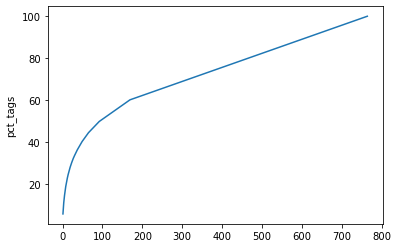

In [10]:
sns.lineplot(x = df_tags_unique.index + 1, y = df_tags_unique['pct_tags'])

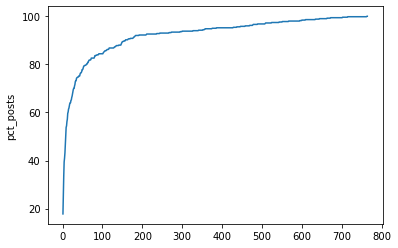

In [11]:
sns.lineplot(x = df_tags_unique.index + 1, y = df_tags_unique['pct_posts'])

In [12]:
df_tags_unique.loc[19, :]

tag            dataframe
n_occurence            9
pct_tags         28.7433
n_posts              320
pct_posts             64
Name: 19, dtype: object

# Modelling

In [13]:
# Define and apply gensim filters
filters = [
           gsp.strip_tags, 
           gsp.strip_punctuation,
           gsp.strip_multiple_whitespaces,
           gsp.strip_numeric,
           gsp.remove_stopwords, 
#            gsp.strip_short, 
           gsp.stem_text
          ]

def clean_text(s):
    s = s.lower()
    s = utils.to_unicode(s)
    for f in filters:
        s = f(s)
    return s

# Custom transformer using gensim filters
class TextCleaner(TransformerMixin):
    def transform(self, X, **transform_params):
        # Cleaning Text
        return [clean_text(text) for text in X]

    def fit(self, X, y=None, **fit_params):
        return self

    def get_params(self, deep=True):
        return {}

In [14]:
pip = Pipeline([('clean', TextCleaner()),
                ('vect', TfidfVectorizer())
               ])

In [15]:
X = df.loc[:, 'Post']

In [16]:
pip.fit(X)

Pipeline(memory=None,
         steps=[('clean', <__main__.TextCleaner object at 0x000001F61A0474C8>),
                ('vect',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None))],
         verbose=False)

In [17]:
X_prep = pip.transform(X)

In [18]:
X_prep

<500x7483 sparse matrix of type '<class 'numpy.float64'>'
	with 29148 stored elements in Compressed Sparse Row format>

In [19]:
from sklearn.decomposition import NMF, LatentDirichletAllocation

In [20]:
n_samples = 500
n_features = 7483
n_components = 10
n_top_words = 20

In [21]:
nmf = NMF(n_components = n_components)

In [22]:
nmf.fit(X_prep)

NMF(alpha=0.0, beta_loss='frobenius', init=None, l1_ratio=0.0, max_iter=200,
    n_components=10, random_state=None, shuffle=False, solver='cd', tol=0.0001,
    verbose=0)

In [23]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()

In [24]:
print("\nTopics in NMF model (Frobenius norm):")
tfidf_feature_names = pip['vect'].get_feature_names()
print_top_words(nmf, tfidf_feature_names, n_top_words)


Topics in NMF model (Frobenius norm):
Topic #0: gt lt span button td class xml data type function form php rout mean style compon li templat mpg pin
Topic #1: list valu string int function arrai foo map kei number return print void split code size check variabl want filter
Topic #2: df datafram column pd valu na index nan data panda timestamp row time featur output seri np mean vector like
Topic #3: id user movi item friend tabl privat entiti class person public demand select button gt databas creat custom mail statu
Topic #4: div px class lt text imag gt span width margin background tr grid item img element height box color react
Topic #5: java org springframework bean redi flag class groovi factori public unknown sourc aspectj spark method annot artifactori retrofit support com
Topic #6: test error run app node js build messag aw email data com http us request api user modul respons script
Topic #7: date column datetim null queri tabl valu obj type object field end data laravel subt

In [25]:
lda = LatentDirichletAllocation(n_components = n_components)
lda.fit(X_prep)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='batch', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=10, n_jobs=None,
                          perp_tol=0.1, random_state=None,
                          topic_word_prior=None, total_samples=1000000.0,
                          verbose=0)

In [26]:
print("\nTopics in LDA:")
tfidf_feature_names = pip['vect'].get_feature_names()
print_top_words(lda, tfidf_feature_names, n_top_words)


Topics in LDA:
Topic #0: valu gt arrai data row df lt num text list count output graph result column screen check new var span
Topic #1: id gt lt column date user data tabl time queri function valu creat like item select end class product code
Topic #2: null user player tabl data privat id grid print lt set tweet line queri gt python interv return lat long
Topic #3: index gt column list titl datafram df valu pd id mean np friend address arrai function import mpg ftp job
Topic #4: karat valu repo seri file email banana char write codekit contact program delet fr th string uiview myccpobject timex jest
Topic #5: gt lt div class valu id file type string kei text data event date field html item user properti error
Topic #6: gt lt file int function run error test py number python id class path td string list work user script
Topic #7: movi map aw testschip list std xmm weight string uri sort gyp assert gt defin warn projector person dask channel
Topic #8: gt lt px self class test com width